In [12]:
regions = [11]
scenarios = ['ssp126','ssp245', 'ssp370', 'ssp585']
vns = ['mass_annual','area_annual', 'runoff_fixed_monthly']

agg_fp = '/Volumes/LaCie/glacier_stats/'
normyear = 2000

group_dict_fullfn = '/Users/laurenoh/Desktop/research/PyGEM-analysis/rgi60_watershed_dict.csv'
group_cn = 'watershed'

group_min_glaciers = 50 # only include a given group if there is a critical number

merge_hma = True # option to merge HMA together (useful for watersheds or other groups that span multiple regions)

plot_norm = True # option to plot normalized figures or not

debug = True # Set True for extra print statements to check correct

In [13]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter
import xarray as xr

try:
    import pygem
except:
    sys.path.append(os.getcwd() + '/../PyGEM/')
import pygem.pygem_modelsetup as modelsetup

In [14]:

ds_vn_dict = {'mass_annual':'glac_mass_annual',
              'area_annual':'glac_area_annual',
              'runoff_fixed_monthly':'glac_runoff_fixed_monthly'}
scenario_colordict = {'ssp119':'#081d58', 
                      'ssp126':'#1d91c0', 
                      'ssp245':'#7fcdbb', 
                      'ssp370':'#F47A20', 
                      'ssp585':'#ED2024'}
rgi_reg_dict = {'all':'Global',
                'global':'Global',
                1:'Alaska',
                2:'W Canada & US',
                3:'Arctic Canada North',
                4:'Arctic Canada South',
                5:'Greenland Periphery',
                6:'Iceland',
                7:'Svalbard',
                8:'Scandinavia',
                9:'Russian Arctic',
                10:'North Asia',
                11:'Central Europe',
                12:'Caucasus & Middle East',
                13:'Central Asia',
                14:'South Asia West',
                15:'South Asia East',
                16:'Low Latitudes',
                17:'Southern Andes',
                18:'New Zealand',
                19:'Antarctic & Subantarctic'
                }
scenario_namedict = {'rcp26':'RCP2.6',
                     'rcp45':'RCP4.5',
                     'rcp85':'RCP8.5',
                     'ssp119':'SSP1-1.9',
                     'ssp126':'SSP1-2.6',
                     'ssp245':'SSP2-4.5',
                     'ssp370':'SSP3-7.0',
                     'ssp585':'SSP5-8.5'}

In [15]:
# Group Dictionary
group_csv = pd.read_csv(group_dict_fullfn)
group_dict = dict(zip(group_csv.RGIId, group_csv[group_cn]))

In [16]:
for region in regions:
    
    for nvn, vn in enumerate(vns): #vn:'mass_annual', 'area_annual', 'runoff_fixed_monthly'
        print(vn)
        # Filepath
        ds_fp = agg_fp + '/' + vn + '/' + str(region) + '/'
        # Dataset variable name
        ds_vn = ds_vn_dict[vn] #glac_mass, glac_area
        
        for nscenario, scenario in enumerate(scenarios):
            print(scenario)
            # Filenames (lists enable batches which are used for runoff)
            ds_fns = []
            ds_fns_int = []
            for i in os.listdir(ds_fp):
                if not i.startswith("."):
                    if str(region) in i and vn in i and scenario in i:
                        ds_fns.append(i)
                        if 'Batch' in i:
                            ds_fns_int.append(int(i.split('-')[-2]))

            # Sort filenames
            if len(ds_fns_int) > 0:
                ds_fns = [x for _,x in sorted(zip(ds_fns_int, ds_fns))]

            # Load data (aggregate if necessary)
            for nfn, ds_fn in enumerate(ds_fns):
                if nfn == 0:
                    ds = xr.open_dataset(ds_fp + ds_fn)
                else:
                    ds_batch = xr.open_dataset(ds_fp + ds_fn)
                    ds = xr.concat((ds, ds_batch), dim='glacier')
        
            
            
            if nvn + nscenario == 0:
                glacno_list = [x.split('-')[1] for x in ds.RGIId.values]
                main_glac_rgi_reg = modelsetup.selectglaciersrgitable(glac_no=glacno_list)
                main_glac_rgi_reg[group_cn] = main_glac_rgi_reg.RGIId.map(group_dict)

            
                # unique groups
                groups_unique = list(main_glac_rgi_reg[group_cn].unique())
                groups_count = {}
                groups_idxs = {}
                for group in groups_unique:
                    main_glac_rgi_group = main_glac_rgi_reg.loc[main_glac_rgi_reg[group_cn] == group]
                    if main_glac_rgi_group.shape[0] > group_min_glaciers:
                        groups_count[group] = main_glac_rgi_group.shape[0]
                        groups_idxs[group] = list(main_glac_rgi_group.index.values)
                groups_unique = list(groups_count.keys())

            # Get time series for each group and GCM
            for ngroup, group in enumerate(groups_unique):
                ds_vn_values = ds[ds_vn].values
                ds_vn_values_group = ds_vn_values[:,groups_idxs[group],:].sum(1)

                if ngroup == 0:
                    groups_vn_values = ds_vn_values_group[np.newaxis,:,:]
                else:
                    groups_vn_values = np.concatenate((groups_vn_values, ds_vn_values_group[np.newaxis,:,:]), axis=0)

            # Create new xarray dataset based on groups
            ds_group = ds.copy()
            # create new variable
            ds_vn_group = ds_vn.replace('glac','group')
            ds_group[ds_vn_group] = ds_group[ds_vn]
            # drop the glacier variable
            ds_group = ds_group[ds_vn_group].sel(glacier=1, drop=True).to_dataset()
            # add back attributes that were lost in conversion to data array above
            ds_group.attrs = ds.attrs
            # create new coordinate for group
            ds_group['group'] = groups_unique
            # save data array that expands the dimension of the variables to include groups
            ds_group_array = ds_group[ds_vn_group].expand_dims(group=groups_unique)
            # update dataset variable with the data array
            ds_group[ds_vn_group] = ds_group_array
            # update the values
            ds_group[ds_vn_group].values = groups_vn_values


            # Export aggregated dataset
            if 'Batch' in ds_fn:
                # remove Batch from filename since now its aggregated
                ds_group_fn = ds_fn.replace('glac', group_cn).split('-')[0] + '-' + ds_fn.split('-')[1] + '.nc'
            else:
                ds_group_fn = ds_fn.replace('glac', group_cn)
            ds_group_fp = agg_fp + group_cn + '/' + vn + '/' + str(region).zfill(2) + '/'
            if not os.path.exists(ds_group_fp):
                os.makedirs(ds_group_fp)
            ds_group.to_netcdf(ds_group_fp + ds_group_fn)
      

mass_annual
ssp126
3925 glaciers in region 11 are included in this model run: ['00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042', '00043', '00044', '00045', '00046', '00047', '00048', '00049', '00050'] and more
This study is focusing on 3925 glaciers in region [11]
ssp245
ssp370
ssp585
area_annual
ssp126
ssp245
ssp370
ssp585


In [17]:
scenario

'ssp585'

In [18]:
ds_group #use this to find peakwater

<xarray.Dataset>
Dimensions:            (model: 12, year: 102, group: 4)
Coordinates:
    Climate_Model      (model) object ...
  * year               (year) int64 2000 2001 2002 2003 ... 2098 2099 2100 2101
  * group              (group) object 'Danube' 'Rhine' 'Po' 'Rhone'
Dimensions without coordinates: model
Data variables:
    group_area_annual  (group, model, year) float64 3.479e+08 ... 2.015e+07
Attributes:
    Region:       11 - Central Europe
    source:       PyGEMv0.1.0
    institution:  Carnegie Mellon University
    history:      Created by David Rounce (drounce@cmu.edu) on January 30 2021
    references:   doi:10.3389/feart.2019.00331 and doi:10.1017/jog.2019.91
    Conventions:  CF-1.9
    featureType:  timeSeries

mass_annual
area_annual


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


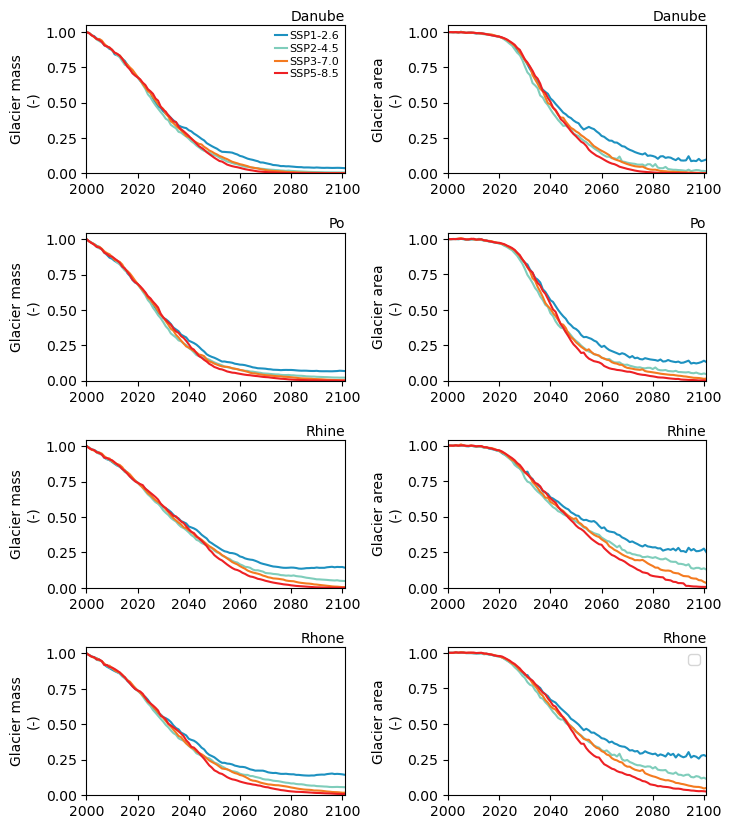

In [19]:
groups_unique = sorted(groups_unique)
for region in regions:
    
    fig, ax = plt.subplots(len(groups_unique), len(vns), squeeze=False, sharex=False, sharey=False, 
                       gridspec_kw = {'wspace':0.4, 'hspace':0.4})
    
    for nvn, vn in enumerate(vns):
        print(vn)
        
        # Filepath
        if type(region) is str:
            region_str = region
        else:
            region_str = str(region).zfill(2)
        ds_group_fp = agg_fp + group_cn + '/' + vn + '/' + region_str + '/'
        
        # Dataset variable name
        ds_vn = ds_vn_dict[vn].replace('glac', 'group')
        
        for ngroup, group in enumerate(groups_unique):
            for nscenario, scenario in enumerate(scenarios):
                # Filename
                for i in os.listdir(ds_group_fp):
                    if str(region) in i and vn in i and scenario in i:
                        ds_fn = i
     
                # Load data
                ds = xr.open_dataset(ds_group_fp + ds_fn)
                
                # Group idx
                group_idx = list(ds.group.values).index(group)

                # Aggregate data
                if 'annual' in ds_vn:
                    ds_med = ds[ds_vn].sel(group=group).median(dim='model')
                    ds_std = ds[ds_vn].sel(group=group).std(dim='model')
                    time_values = ds.year.values
                elif 'monthly' in ds_vn:
                    ds_med = ds[ds_vn].sel(group=group).resample(time='Y').sum('time').median('model')
                    ds_std = ds[ds_vn].sel(group=group).resample(time='Y').sum('time').std('model')
                    time_values = np.array([int(x) for x in pd.DatetimeIndex(ds_med.time.values).year])

                # Plot data
                normyear_idx = np.where(time_values == normyear)[0][0]
                ds_med_values = ds_med.values
                # Smooth runoff with 11-year running mean
                if 'runoff' in ds_vn:
                    ds_med_values = uniform_filter(ds_med_values, size=(11))

                if ngroup + nvn == 0:
                    label = scenario_namedict[scenario]
                else:
                    label = None

                if plot_norm:
                    ax[ngroup, nvn].plot(time_values, ds_med_values/ds_med_values[normyear_idx], 
                                         color=scenario_colordict[scenario], label=label)
                else:
                    ax[ngroup, nvn].plot(time_values, ds_med_values,
                                         color=scenario_colordict[scenario])

                # Bounds
                ax[ngroup, nvn].set_ylim(0)
                ax[ngroup, nvn].set_xlim(time_values[0], time_values[-1])
                
                # Add Labels
                try:
                    ylabel_wunits = ds[ds_vn].long_name + '\n(' + ds[ds_vn].units + ')'
                except:
                    ylabel_wunits = ds[ds_vn].long_name + '\n(' + ds[ds_vn].unit + ')'
                ylabel_norm = ds[ds_vn].long_name + '\n(-)'
                if plot_norm:
                    ax[ngroup, nvn].set_ylabel(ylabel_norm, size=10)
                else:
                    ax[ngroup, nvn].set_ylabel(ylabel_wunits, size=10)
                
                
                # Group label
                if nscenario == 0:
                    ax[ngroup, nvn].text(1, 1.01, group, size=10, horizontalalignment='right', 
                                         verticalalignment='bottom', transform=ax[ngroup,nvn].transAxes)

            
            # Add legend
            if ngroup + nvn == 0:
                ax[ngroup,nvn].legend(loc='upper right', fontsize=8, ncol=1, columnspacing=0.5, labelspacing=0.25, 
                               handlelength=1, handletextpad=0.25, borderpad=0, frameon=False)
            
                
    fig.set_size_inches(4*len(vns), 2.5*len(groups_unique))
    fig.savefig('Central_Europe_Graph.png')
    plt.legend()
    plt.show()
    

In [14]:
def peakwater(runoff, time_values, nyears):
    """Compute peak water based on the running mean of N years
    
    Parameters
    ----------
    runoff : np.array #find time series in numpy runoff by one watershed one scenario #just runoff and time/ get rid of model, watershed #maybe loop thru
        one-dimensional array of runoff for each timestep
        #index the ds_group to get index specific watershed for xarray
        #ds_group.loc[dict(group = 'Danube ... loop thru', model = 1)]
        #email david abt where to find scenario 
        #ds.loc[dict(space='IA')]
        
    time_values : np.array
        time associated with each timestep
        #index ds_gorup time
        # example: ds_group.coords['time'].values
        
    nyears : int
        number of years to compute running mean used to smooth peakwater variations
        
    Output
    ------
    peakwater_yr : int
        peakwater year
    peakwater_chg : float
        percent change of peak water compared to first timestep (running means used)
    runoff_chg : float
        percent change in runoff at the last timestep compared to the first timestep (running means used)
    """
    
    runningmean = uniform_filter(runoff, size=(nyears))
    peakwater_idx = np.where(runningmean == runningmean.max())[-1][0]
    peakwater_yr = time_values[peakwater_idx]
    peakwater_chg = (runningmean[peakwater_idx] - runningmean[0]) / runningmean[0] * 100
    runoff_chg = (runningmean[-1] - runningmean[0]) / runningmean[0] * 100
    return peakwater_yr, peakwater_chg, runoff_chg

(numpy.datetime64('2026-12-31T00:00:00.000000000'), 20.677305781202765, -26.0113959183541)
958066851.5602072
(numpy.datetime64('2027-12-31T00:00:00.000000000'), 16.130146007425132, -25.700310342137193)
1221743737.4566696
(numpy.datetime64('2027-12-31T00:00:00.000000000'), 20.38506796877159, -29.50796346805752)
1517323943.3005774
(numpy.datetime64('2027-12-31T00:00:00.000000000'), 19.712814689015907, -28.951598316313053)
2455608712.771829


Text(0.5, 1.0, 'Central Europe Glacier Runoff and Peakwater')

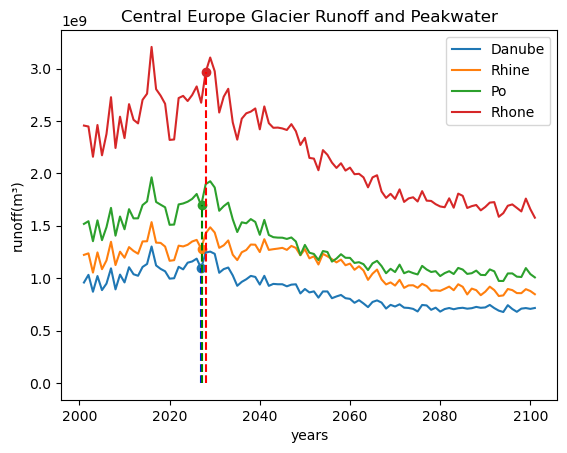

In [46]:
watershed = ['Danube', 'Rhine', 'Po','Rhone']
for i,ws in enumerate(watershed):
    dsr = ds_group['group_runoff_fixed_monthly']
    ds_gcmmean = dsr.mean('model')
    ds_runoff = ds_gcmmean.resample(time='y').sum()
    ds_runoff1 = ds_runoff.sel(group = ws)
    ds_numpy = ds_runoff1.to_numpy()
    runoff, time_values, nyears = ds_numpy, ds_runoff.coords['time'].values, 11
    plt.plot(ds_runoff.coords['time'].values, ds_numpy, label = ws)
    pw = peakwater(runoff, time_values, nyears) #peakwater_yr, peakwater_chg, runoff_chg
    print(pw)
    print(ds_numpy[0])
    plt.legend()

a , b = [np.datetime64('2026-12-31T00:00:00.000000000')], [1094253070.4733803] #danube
plt.scatter(a,b)
e, f =  [np.datetime64('2027-03-31T00:00:00.000000000')], [1281027513.975461] #rhine
plt.scatter(e,f)
g, h = [np.datetime64('2027-03-31T00:00:00.000000000')],[1693345728.8247046] #Po
plt.scatter(g,h)
c, d = [np.datetime64('2027-12-31T00:00:00.000000000')], [2966593742.181963] #rhone
plt.scatter(c,d)
plt.vlines(x=np.datetime64('2026-12-31T00:00:00.000000000'), ymin=0, ymax=1094253070.4733803, color='b', zorder=2, linestyle = {'dashed'})
plt.vlines(x=np.datetime64('2027-03-31T00:00:00.000000000'), ymin=0, ymax=1281027513.975461, color='#F47A20', zorder=2, linestyle = {'dashed'})
plt.vlines(x=np.datetime64('2027-03-31T00:00:00.000000000'), ymin=0, ymax=1693345728.8247046, color='g', zorder=2, linestyle = {'dashed'})
plt.vlines(x=np.datetime64('2027-12-31T00:00:00.000000000'), ymin=0, ymax=2966593742.181963, color='r', zorder=2, linestyle = {'dashed'})
plt.xlabel("years")
plt.ylabel("runoff(m³)")
plt.title("Central Europe Glacier Runoff and Peakwater")

2535971425.5669756


(numpy.datetime64('2020-12-31T00:00:00.000000000'),
 18.028294293894394,
 -27.372895003749615)

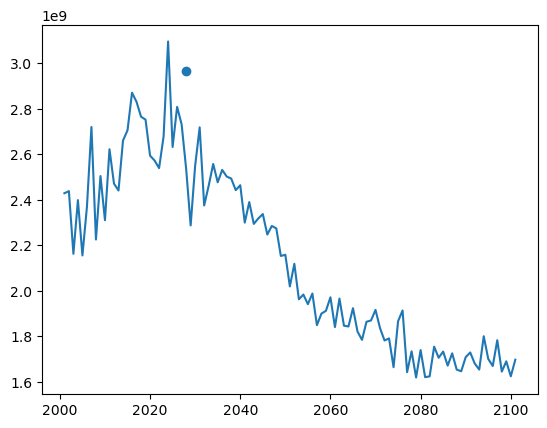

In [93]:
dsr = ds_group['group_runoff_fixed_monthly']
ds_gcmmean = dsr.mean('model')
ds_runoff = ds_gcmmean.resample(time='y').sum()
ds_runoff1 = ds_runoff.sel(group = 'Rhone')
ds_numpy = ds_runoff1.to_numpy()
runoff, time_values, nyears = ds_numpy, ds_runoff.coords['time'].values, 11
x , y = [np.datetime64('2027-12-31T00:00:00.000000000')], [2966593742.181963]
plt.scatter(x,y)
print(runoff[27])
plt.plot(ds_runoff.coords['time'].values, ds_numpy)
peakwater(runoff, time_values, nyears) #peakwater_yr, peakwater_chg, runoff_chg
# x = peakwater(runoff, time_values, nyears)[0]
# print(x)
# xi = int(x)
# x.split('-')
#18% more runoff at peakwater, -27 percent less runoff at the end of century (multiply this percent by the year 2000 runoff)

1094253070.4733803
2026-12-31T00:00:00.000000000


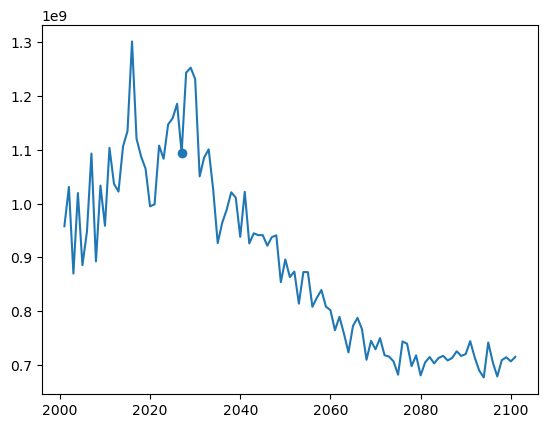

In [48]:
dsr = ds_group['group_runoff_fixed_monthly']
ds_gcmmean = dsr.mean('model')
ds_runoff = ds_gcmmean.resample(time='y').sum()
ds_runoff1 = ds_runoff.sel(group = 'Danube')
ds_numpy = ds_runoff1.to_numpy()
runoff, time_values, nyears = ds_numpy, ds_runoff.coords['time'].values, 11
x , y = [np.datetime64('2026-12-31T00:00:00.000000000')], [1094253070.4733803]
plt.scatter(x,y)
print(runoff[26])
plt.plot(ds_runoff.coords['time'].values, ds_numpy)
peakwater(runoff, time_values, nyears) #peakwater_yr, peakwater_chg, runoff_chg
x = peakwater(runoff, time_values, nyears)[0]
print(x)

1281027513.975461
2027-12-31T00:00:00.000000000


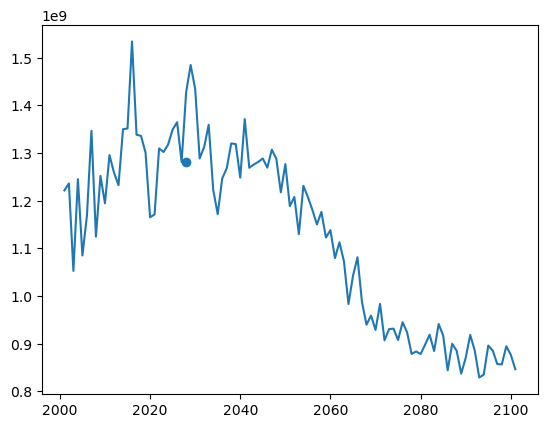

In [21]:
dsr = ds_group['group_runoff_fixed_monthly']
ds_gcmmean = dsr.mean('model')
ds_runoff = ds_gcmmean.resample(time='y').sum()
ds_runoff1 = ds_runoff.sel(group = 'Rhine')
ds_numpy = ds_runoff1.to_numpy()
runoff, time_values, nyears = ds_numpy, ds_runoff.coords['time'].values, 11
x , y = [np.datetime64('2027-12-31T00:00:00.000000000')], [1281027513.975461]
plt.scatter(x,y)
print(runoff[26])
plt.plot(ds_runoff.coords['time'].values, ds_numpy)
peakwater(runoff, time_values, nyears) #peakwater_yr, peakwater_chg, runoff_chg
x = peakwater(runoff, time_values, nyears)[0]
print(x)

1693345728.8247046
2027-12-31T00:00:00.000000000


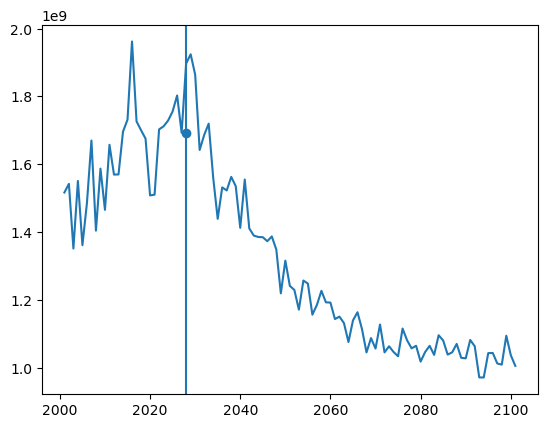

In [57]:
dsr = ds_group['group_runoff_fixed_monthly']
ds_gcmmean = dsr.mean('model')
ds_runoff = ds_gcmmean.resample(time='y').sum()
ds_runoff1 = ds_runoff.sel(group = 'Po')
ds_numpy = ds_runoff1.to_numpy()
runoff, time_values, nyears = ds_numpy, ds_runoff.coords['time'].values, 11
x , y = [np.datetime64('2027-12-31T00:00:00.000000000')], [1693345728.8247046]
plt.scatter(x,y)
print(runoff[26])
plt.plot(ds_runoff.coords['time'].values, ds_numpy)
peakwater(runoff, time_values, nyears) #peakwater_yr, peakwater_chg, runoff_chg
x = peakwater(runoff, time_values, nyears)[0]
print(x)
plt.axvline(np.datetime64('2027-12-31T00:00:00.000000000'), ymax = 1693345728.8247046 )

AttributeError: 'Timestamp' object has no attribute 'astype'

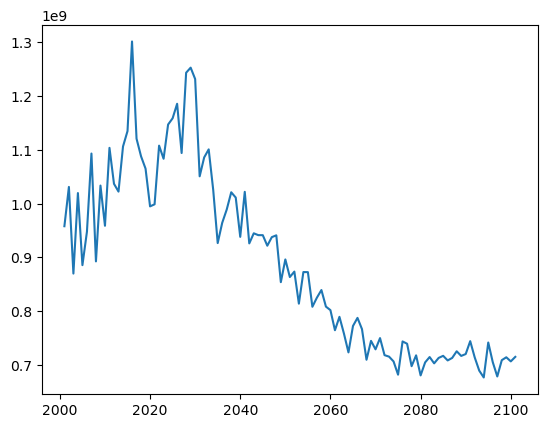

In [72]:
ws = ['Danube', 'Rhine', 'Po','Rhone']
colors = ['y','r','g','b','#A9A9A9','#FF1493']
time = []
ro = [1094253070.4733803,1281027513.975461,1693345728.8247046,2966593742.181963]
for i,w in enumerate(ws):
    dsr = ds_group['group_runoff_fixed_monthly']
    ds_gcmmean = dsr.mean('model')
    ds_runoff = ds_gcmmean.resample(time='y').sum()
    ds_runoff1 = ds_runoff.sel(group = w)
    ds_numpy = ds_runoff1.to_numpy()
    runoff, time_values, nyears = ds_numpy, ds_runoff.coords['time'].values, 11
    plt.plot(ds_runoff.coords['time'].values, ds_numpy, label = w)
    pw = peakwater(runoff, time_values, nyears) #peakwater_yr, peakwater_chg, runoff_chg
    x = pd.to_datetime(pw[0])
    time.append(x)
    intx= x.astype(int)
    print(x.type)
    print(time)
    plt.scatter(x[i],y[i])
    print(x.year)
    print(w)
    plt.legend()
    

In [8]:
print(ds_group.coords['group'].values)

['Danube' 'Rhine' 'Po' 'Rhone']


In [25]:
%matplotlib inline

11


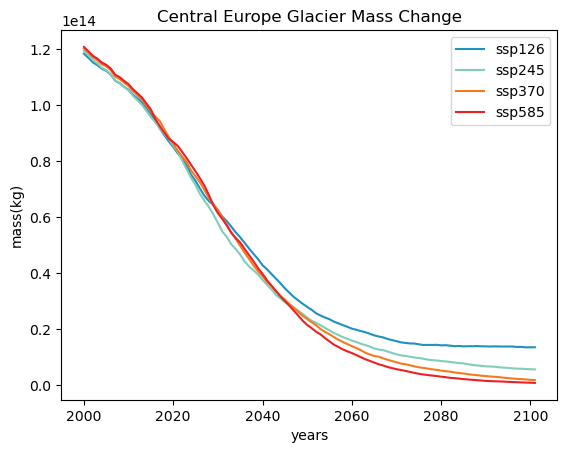

<Figure size 640x480 with 0 Axes>

In [13]:
colors = ['#1d91c0','#7fcdbb','#F47A20','#ED2024']
for region in regions:
    print(region)
    for i,scenario in enumerate(scenarios): 
        ds_mass_fn = '/Volumes/LaCie/glacier_stats/mass_annual/11/R11_glac_mass_annual_50sets_2000_2100-'+scenario+'.nc' 
        ds = xr.open_dataset(ds_mass_fn)
        #HOW TO USE LOOP TO CREATE A COMBINED PLOT
        glac_mass_annual = ds.glac_mass_annual.values
        reg_mass_annual = np.sum(glac_mass_annual, axis=1)
        reg_mass_annual_mean = np.mean(reg_mass_annual, axis=0)
        X = ds.coords['year'].values
        Y = reg_mass_annual_mean
        plt.plot(X, Y, color = colors[i], label = str(scenario))
        plt.xlabel("years")
        plt.ylabel("mass(kg)")
        plt.title("Central Europe Glacier Mass Change")
        plt.legend()
        #color variable?
    plt.show()
    plt.savefig('CE Glacier Mass Change')

11


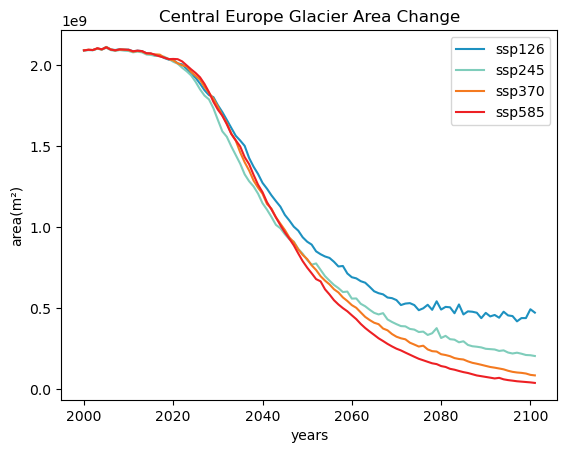

<Figure size 640x480 with 0 Axes>

In [6]:
colors = ['#1d91c0','#7fcdbb','#F47A20','#ED2024']
for region in regions:
    print(region)
    for i,scenario in enumerate(scenarios): 
        ds_area_fn = '/Volumes/LaCie/glacier_stats/area_annual/11/R11_glac_area_annual_50sets_2000_2100-'+scenario+'.nc' 
        ds = xr.open_dataset(ds_area_fn)
        #HOW TO USE LOOP TO CREATE A COMBINED PLOT
        glac_area_annual = ds.glac_area_annual.values
        reg_area_annual = np.sum(glac_area_annual, axis=1)
        reg_area_annual_mean = np.mean(reg_area_annual, axis=0)
        X = ds.coords['year'].values
        Y = reg_area_annual_mean
        plt.plot(X, Y, color = colors[i], label = str(scenario))
        plt.xlabel("years")
        plt.ylabel("area(m²)")
        plt.title("Central Europe Glacier Area Change")
        plt.legend()
        #color variable?
    plt.show()
    plt.savefig('CE Glacier Area Change')